# MagNet: Model the Geomagnetic Field:
This notebook describes the benchmark LSTM model for the MagNet challenge.

## Acknowledgements:

Points of contact: Rob Redmon and Manoj Nair at NOAA

Topics on Explainable AI (XAI) (e.g. Feature Importance, Case Studies) are new and were created for the NCAR and [AI2ES](https://www.ai2es.org/) Trustworthy Artificial Intelligence for Environmental Science Summer School ([TAI4ES](https://www2.cisl.ucar.edu/events/tai4es-2022-summer-school)). Code through model training adapted from DrivenData blogpost supporting NOAA's MagNet crowd sourced challenge. 
* https://ngdc.noaa.gov/geomag/mag-net-challenge.html
* https://www.drivendata.co/blog/model-geomagnetic-field-benchmark/

Documentation aligned with and adapted from:
https://github.com/liyo6397/MagNet/blob/master/magnet_cnn_tutorial.ipynb
(See also that repository for additional architectures including the MagNet challenge winning solutions, e.g. the CNN ensemble using cross-validation-folds approach).

## Background on Geospace Space Weather

TBD: Describe the basics of the solar wind impinging on Geospace and the range of potential effects to humans and technological systems. Link to SWPC dashboards.

![HELIO_GRAPHIC_URL](https://ngdc.noaa.gov/geomag/img/challenge-banner.png "HELIO")

## Background on the Geomagnetic Field

The efficient transfer of energy from solar wind into the Earth’s magnetic field causes geomagnetic storms. The resulting variations in the magnetic field increase errors in magnetic navigation. The disturbance-storm-time index, or Dst, is a measure of the severity of the geomagnetic storm.

As a key specification of the magnetospheric dynamics, the Dst index is used to drive geomagnetic disturbance models such as NOAA/NCEI’s High Definition Geomagnetic Model - Real-Time (HDGM-RT).
![HDGMRT_GRAPHIC_URL](https://www.ngdc.noaa.gov/geomag/HDGM/images/HDGM-RT_2003_storm_720p.gif "HDGM-RT")
 
In 2020-2021, NOAA and NASA conducted an international crowd sourced data science competition “MagNet: Model the Geomagnetic Field”:
https://www.drivendata.org/competitions/73/noaa-magnetic-forecasting/
 
Empirical models have been proposed as early as in 1975 to forecast DST solely from solar-wind observations at the Lagrangian (L1) position by satellites such as NOAA’s Deep Space Climate Observatory (DSCOVR) or NASA's Advanced Composition Explorer (ACE). Over the past three decades, several models were proposed for solar wind forecasting of DST, including empirical, physics-based, and machine learning approaches. While the ML models generally perform better than models based on the other approaches, there is still room to improve, especially when predicting extreme events. More importantly, we intentionally sought solutions that work on the raw, real-time data streams and are agnostic to sensor malfunctions and noise.

## Modeling Task

The MagNet competition task was to develop models for forecasting DST that push the boundary of predictive performance, under operationally viable constraints, using the real-time solar-wind (RTSW) data feeds from NOAA’s DSCOVR and NASA’s ACE satellites. Improved models can provide more advanced warning of geomagnetic storms and reduce errors in magnetic navigation systems. Specifically, given one week of data ending at t minus 1 minute, the model must forecast DST at time t and t plus one hour.

The model described in this notebook is the benchmark model provided by the MagNet competition organizers. Long Short Term Memory networks or LSTMs are a special kind of recurrent neural network especially suited to time series data. In the related notebook, we will show you how to implement a first-pass LSTM model for predicting Dst.

## Data Notes

The target DST values are measured by 4 ground-based observatories near the equator. These values are then averaged to provide a measurement of DST for any given hour.
To ensure similar distributions between the training and test data, the data is separated into three non-contiguous periods. All data are provided with a `period` and `timedelta` multi-index which indicates the relative timestep for each observation within a period, but not the real timestamp. The period identifiers and timedeltas are common across datasets.

There are 3 sources of input data:
* Measurements of the solar wind, including direction, speed, density and temperature, at 1-minute frequency.
* Position of the satellite used for solar wind measurements (this was not used in our solution, since we found it did not improve the model).
* Number of sunspots, measured monthly.

TODO: Add a stack plot for a typical event from solar wind to Dst, Kp, AE.

## Python Requirements

<div class="alert alert-block alert-warning">The following dependencies are required.
TBD modules list
</div>

# Acquire and Explore Data

In [129]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#%load_ext nb_black                # Nice for iPython, not available for Colab.
%matplotlib inline

## Data Summary
The competition discussed above used <i>public</i> data for development and the public leaderboard. A <i>private</i> dataset was kept internal during the competition for use in scoring by organizers. Since the competition has passed, both datasets are publicly accessible at NOAA. We will build and evaulate the model using the competition's <i>public</i> data and evaluate storm event case studies using the competition's <i>private</i> data. 

In [130]:
%%capture captured_io
%%bash
# download the data
if [ ! -d "data" ]; then
  wget --verbose https://ngdc.noaa.gov/geomag/data/geomag/magnet/public.zip
  wget --verbose https://ngdc.noaa.gov/geomag/data/geomag/magnet/private.zip
  unzip public.zip
  unzip private.zip
  mkdir -v data
  mv -v public private data/
  mv -v public.zip private.zip data/
fi
# Uncomment for debugging if you have trouble downloading:
#print(captured_io)

In [131]:
DATA_PATH = Path("data/public/")

dst = pd.read_csv(DATA_PATH / "dst_labels.csv")
dst.timedelta = pd.to_timedelta(dst.timedelta)
dst.set_index(["period", "timedelta"], inplace=True)

sunspots = pd.read_csv(DATA_PATH / "sunspots.csv")
sunspots.timedelta = pd.to_timedelta(sunspots.timedelta)
sunspots.set_index(["period", "timedelta"], inplace=True)

solar_wind = pd.read_csv(DATA_PATH / "solar_wind.csv")
solar_wind.timedelta = pd.to_timedelta(solar_wind.timedelta)
solar_wind.set_index(["period", "timedelta"], inplace=True)

satellite_positions = pd.read_csv(DATA_PATH / "satellite_positions.csv")
satellite_positions.timedelta = pd.to_timedelta(satellite_positions.timedelta)
satellite_positions.set_index(["period", "timedelta"], inplace=True)

## Data Exploration

In [132]:
print("Dst shape: ", dst.shape)
dst.head()

Dst shape:  (139872, 1)


dst
period  timedelta           
train_a 0 days 00:00:00   -7
        0 days 01:00:00  -10
        0 days 02:00:00  -10
        0 days 03:00:00   -6
        0 days 04:00:00   -2

In [133]:
dst.groupby("period").describe()

dst                                                    
           count       mean        std    min   25%   50%  75%   max
period                                                              
train_a  28824.0 -16.576707  26.083191 -387.0 -26.0 -12.0 -1.0  65.0
train_b  52584.0  -9.695154  16.443049 -223.0 -17.0  -7.0  1.0  59.0
train_c  58464.0  -9.556325  16.506404 -374.0 -16.0  -7.0  0.0  67.0

## Visualize the difference between the periods

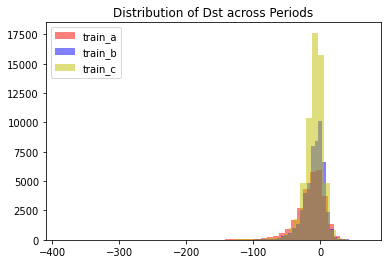

In [134]:
fig, ax = plt.subplots()
colors = ["r", "b", "y"]
for i, period in enumerate(dst.groupby("period")):
    period_name, df = period
    # FYI: For Colaborory (Python 3.7), in the call to ax.hist(), you need to transpose the DataFrame.
    #      For Python 3.8+ it seems no tranpose is needed, thus this version switch.
    #      Error message you might see if DataFrame isn't oriented correctly: 
    #           "ValueError: color kwarg must have one color per data set. 28824 data sets and 1 colors were provided"
    import sys
    if float(sys.version[:3]) <= 3.7:
        ax.hist(df.T, alpha=0.5, color=colors[i], bins=50, label=period_name)
    else:
        ax.hist(df,   alpha=0.5, color=colors[i], bins=50, label=period_name)

plt.legend()
plt.title("Distribution of Dst across Periods")
plt.show()

In [135]:
print("Solar wind shape: ", solar_wind.shape)
solar_wind.head(n=3)

Solar wind shape:  (8392320, 15)


bx_gse  by_gse  bz_gse  theta_gse  phi_gse  bx_gsm  \
period  timedelta                                                             
train_a 0 days 00:00:00   -5.55    3.00    1.25      11.09   153.37   -5.55   
        0 days 00:01:00   -5.58    3.16    1.17      10.10   151.91   -5.58   
        0 days 00:02:00   -5.15    3.66    0.85       7.87   146.04   -5.15   

                         by_gsm  bz_gsm  theta_gsm  phi_gsm    bt  density  \
period  timedelta                                                            
train_a 0 days 00:00:00    3.00    1.25      11.09   153.37  6.80     1.53   
        0 days 00:01:00    3.16    1.17      10.10   151.91  6.83     1.69   
        0 days 00:02:00    3.66    0.85       7.87   146.04  6.77     1.97   

                          speed  temperature source  
period  timedelta                                    
train_a 0 days 00:00:00  383.92     110237.0     ac  
        0 days 00:01:00  381.79     123825.0     ac  
        0 days 00:02:00  389.11      82548.0     ac

In [136]:
print("Sunspot shape: ", sunspots.shape)
sunspots.head(n=3)

Sunspot shape:  (192, 1)


smoothed_ssn
period  timedelta              
train_a 0 days             65.4
        13 days            72.0
        44 days            76.9

In [137]:
solar_wind.groupby("period").describe().T

period                  train_a       train_b       train_c
bx_gse      count  1.575012e+06  3.084130e+06  3.407290e+06
            mean  -1.781301e+00 -3.088789e-01 -4.619076e-01
            std    4.339212e+00  3.627830e+00  3.245485e+00
            min   -5.463000e+01 -2.937000e+01 -4.546000e+01
            25%   -4.960000e+00 -3.070000e+00 -2.800000e+00
...                         ...           ...           ...
temperature min    1.000000e+04  1.496000e+03  0.000000e+00
            25%    4.364900e+04  3.741400e+04  4.007400e+04
            50%    7.923800e+04  8.552400e+04  7.152100e+04
            75%    1.325500e+05  1.873250e+05  1.310880e+05
            max    6.223700e+06  4.206672e+06  5.751308e+06

[112 rows x 3 columns]

In [138]:
sunspots.groupby("period").describe().T

period                 train_a     train_b    train_c
smoothed_ssn count   40.000000   72.000000  80.000000
             mean   136.902500   51.850000  24.313750
             std     34.563168   39.200266  19.020414
             min     65.400000    3.900000   2.200000
             25%    108.375000   15.325000   7.775000
             50%    151.500000   43.150000  20.500000
             75%    164.400000   91.225000  38.525000
             max    175.200000  116.400000  69.500000

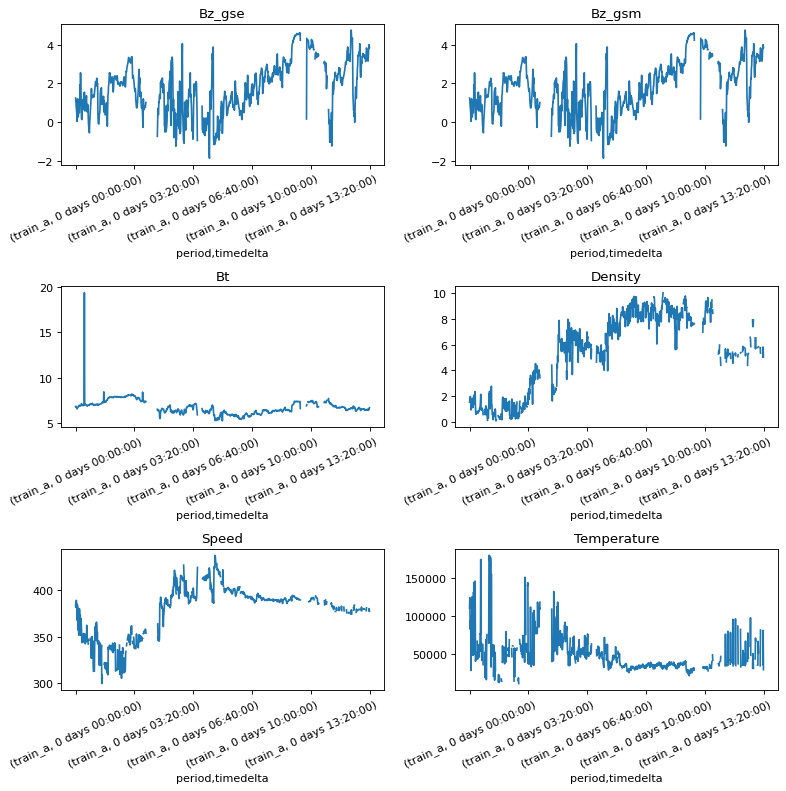

In [139]:
def show_raw_visualization(data):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10), dpi=80)
    for i, key in enumerate(data.columns):
        t_data = data[key]
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            title=f"{key.capitalize()}",
            rot=25,
        )

    fig.subplots_adjust(hspace=0.8)
    plt.tight_layout()

cols_to_plot = ["bz_gse", "bz_gsm", "bt", "density", "speed", "temperature"]
show_raw_visualization(solar_wind[cols_to_plot].iloc[:1000])

## Data gaps are a common issue with real-time data

Let's count those:

In [140]:
solar_wind.isna().sum()

bx_gse         325888
by_gse         325888
bz_gse         325888
theta_gse      325888
phi_gse        326388
bx_gsm         325888
by_gsm         325888
bz_gsm         325888
theta_gsm      325888
phi_gsm        326388
bt             325888
density        684890
speed          689555
temperature    811768
source         316816
dtype: int64

## Feature Relationships

In [141]:
# Correlation matrix:
#     Note that this is slow (several minutes) unless you have a GPU or TPU backend (then it's ~1 min).
corr = solar_wind.join(sunspots).join(satellite_positions).join(dst).fillna(method="ffill").corr()

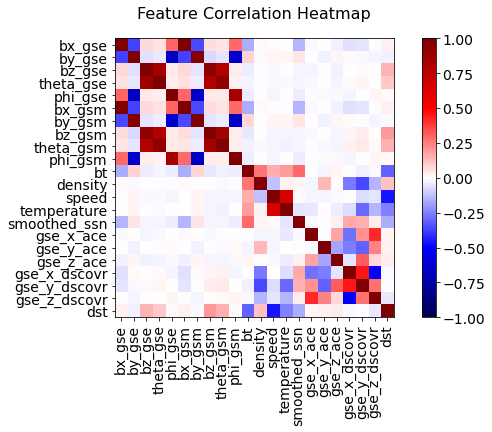

In [142]:
plt.figure(figsize=(10, 5))
plt.matshow(corr, cmap='seismic', vmin=-1, vmax=1, fignum=1)
plt.xticks(range(corr.shape[1]), corr.columns, fontsize=14, rotation=90)
plt.gca().xaxis.tick_bottom()
plt.yticks(range(corr.shape[1]), corr.columns, fontsize=14)


cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.show()

# Feature Generation

## Set seeds for reproducibility

In [143]:
from numpy.random import seed
from tensorflow.random import set_seed

seed(2020)
set_seed(2021)

## Feature / Input Data we'll use to Train the Model

In [144]:
from sklearn.preprocessing import StandardScaler

# subset of solar wind features to use for modeling
SOLAR_WIND_FEATURES = [
    "bt",
    "temperature",
    "bx_gsm",
    "by_gsm",
    "bz_gsm",
    "speed",
    "density",
]

# all of the features we'll use, including sunspot numbers
XCOLS = (
    [col + "_mean" for col in SOLAR_WIND_FEATURES]
    + [col + "_std" for col in SOLAR_WIND_FEATURES]
    + ["smoothed_ssn"]
)


def impute_features(feature_df):
    """Imputes data using the following methods:
    - `smoothed_ssn`: forward fill
    - `solar_wind`: interpolation
    """
    # forward fill sunspot data for the rest of the month
    feature_df.smoothed_ssn = feature_df.smoothed_ssn.fillna(method="ffill")
    # interpolate between missing solar wind values
    feature_df = feature_df.interpolate()
    return feature_df


def aggregate_hourly(feature_df, aggs=["mean", "std"]):
    """Aggregates features to the floor of each hour using mean and standard deviation.
    e.g. All values from "11:00:00" to "11:59:00" will be aggregated to "11:00:00".
    """
    # group by the floor of each hour use timedelta index
    agged = feature_df.groupby(
        ["period", feature_df.index.get_level_values(1).floor("H")]
    ).agg(aggs)
    # flatten hierachical column index
    agged.columns = ["_".join(x) for x in agged.columns]
    return agged


def preprocess_features(solar_wind, sunspots, scaler=None, subset=None):
    """
    Preprocessing steps:
        - Subset the data
        - Aggregate hourly
        - Join solar wind and sunspot data
        - Scale using standard scaler
        - Impute missing values
    """
    # select features we want to use
    if subset:
        solar_wind = solar_wind[subset]

    # aggregate solar wind data and join with sunspots
    hourly_features = aggregate_hourly(solar_wind).join(sunspots)

    # subtract mean and divide by standard deviation
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(hourly_features)

    normalized = pd.DataFrame(
        scaler.transform(hourly_features),
        index=hourly_features.index,
        columns=hourly_features.columns,
    )

    # impute missing values
    imputed = impute_features(normalized)

    # we want to return the scaler object as well to use later during prediction
    return imputed, scaler

In [145]:
features, scaler = preprocess_features(solar_wind, sunspots, subset=SOLAR_WIND_FEATURES)
print(features.shape)
features.head()

(139872, 15)


bt_mean    bt_std  temperature_mean  \
period  timedelta                                               
train_a 0 days 00:00:00  0.499705  2.443614         -0.375267   
        0 days 01:00:00  0.547177 -0.224580         -0.479430   
        0 days 02:00:00  0.739905 -0.770240         -0.574831   
        0 days 03:00:00  0.699098 -0.278783         -0.324709   
        0 days 04:00:00  0.223933 -0.225168         -0.313432   

                         temperature_std  bx_gsm_mean  bx_gsm_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.600307   -0.381727   
        0 days 01:00:00         0.953178    -1.759200   -0.868044   
        0 days 02:00:00        -0.192518    -1.913422   -1.114649   
        0 days 03:00:00         0.325491    -1.810283   -0.783326   
        0 days 04:00:00         0.201600    -1.339730   -0.485151   

                         by_gsm_mean  by_gsm_std  bz_gsm_mean  bz_gsm_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.434424    0.021156     0.292754   -0.645095   
        0 days 01:00:00     0.189021   -0.282845     0.433737   -0.511040   
        0 days 02:00:00     0.193116   -0.831526     0.747220   -0.870482   
        0 days 03:00:00    -0.380282    0.330015     0.603107   -0.282789   
        0 days 04:00:00     0.080228    1.010471     0.454560   -0.471111   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
        0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
        0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   
        0 days 03:00:00   -0.826469  -0.211185     -0.404306     0.218373   
        0 days 04:00:00   -0.601238   1.016033     -0.371487     0.097253   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444  
        0 days 03:00:00      0.139444  
        0 days 04:00:00      0.139444

In [146]:
# check to make sure missing values are filled
assert (features.isna().sum() == 0).all()

In [147]:
YCOLS = ["t0", "t1"]


def process_labels(dst):
    y = dst.copy()
    y["t0"] = y.groupby("period").dst.shift(-1)
    y["t1"] = y.groupby("period").dst.shift(-2)
    return y[YCOLS]


labels = process_labels(dst)
labels.head()

t0    t1
period  timedelta                  
train_a 0 days 00:00:00 -10.0 -10.0
        0 days 01:00:00 -10.0  -6.0
        0 days 02:00:00  -6.0  -2.0
        0 days 03:00:00  -2.0   3.0
        0 days 04:00:00   3.0   5.0

In [148]:
data = labels.join(features)
data.head()

t0    t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                           
train_a 0 days 00:00:00 -10.0 -10.0  0.499705  2.443614         -0.375267   
        0 days 01:00:00 -10.0  -6.0  0.547177 -0.224580         -0.479430   
        0 days 02:00:00  -6.0  -2.0  0.739905 -0.770240         -0.574831   
        0 days 03:00:00  -2.0   3.0  0.699098 -0.278783         -0.324709   
        0 days 04:00:00   3.0   5.0  0.223933 -0.225168         -0.313432   

                         temperature_std  bx_gsm_mean  bx_gsm_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.600307   -0.381727   
        0 days 01:00:00         0.953178    -1.759200   -0.868044   
        0 days 02:00:00        -0.192518    -1.913422   -1.114649   
        0 days 03:00:00         0.325491    -1.810283   -0.783326   
        0 days 04:00:00         0.201600    -1.339730   -0.485151   

                         by_gsm_mean  by_gsm_std  bz_gsm_mean  bz_gsm_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.434424    0.021156     0.292754   -0.645095   
        0 days 01:00:00     0.189021   -0.282845     0.433737   -0.511040   
        0 days 02:00:00     0.193116   -0.831526     0.747220   -0.870482   
        0 days 03:00:00    -0.380282    0.330015     0.603107   -0.282789   
        0 days 04:00:00     0.080228    1.010471     0.454560   -0.471111   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
        0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
        0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   
        0 days 03:00:00   -0.826469  -0.211185     -0.404306     0.218373   
        0 days 04:00:00   -0.601238   1.016033     -0.371487     0.097253   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444  
        0 days 03:00:00      0.139444  
        0 days 04:00:00      0.139444

# Splitting the Data

In [149]:
def get_train_test_val(data, test_per_period, val_per_period):
    """Splits data across periods into train, test, and validation"""
    # assign the last `test_per_period` rows from each period to test
    test = data.groupby("period").tail(test_per_period)
    interim = data[~data.index.isin(test.index)]
    # assign the last `val_per_period` from the remaining rows to validation
    val = interim.groupby("period").tail(val_per_period)
    # the remaining rows are assigned to train
    train = interim[~interim.index.isin(val.index)]
    return train, test, val


train, test, val = get_train_test_val(data, test_per_period=6_000, val_per_period=3_000)

## We can visualize our splits by plotting a horizontal barchart depicting the counts across periods.

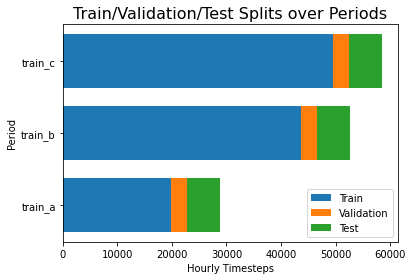

In [150]:
ind = [0, 1, 2]
names = ["train_a", "train_b", "train_c"]
width = 0.75
train_cnts = [len(df) for _, df in train.groupby("period")]
val_cnts = [len(df) for _, df in val.groupby("period")]
test_cnts = [len(df) for _, df in test.groupby("period")]

p1 = plt.barh(ind, train_cnts, width)
p2 = plt.barh(ind, val_cnts, width, left=train_cnts)
p3 = plt.barh(ind, test_cnts, width, left=np.add(val_cnts, train_cnts).tolist())

plt.yticks(ind, names)
plt.ylabel("Period")
plt.xlabel("Hourly Timesteps")
plt.title("Train/Validation/Test Splits over Periods", fontsize=16)
plt.legend(["Train", "Validation", "Test"])

## Final visual inspection of each of our "Training", "Test", and "Validation" datasets

In [151]:
print(train.shape)
train.head()

(112872, 17)


t0    t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                           
train_a 0 days 00:00:00 -10.0 -10.0  0.499705  2.443614         -0.375267   
        0 days 01:00:00 -10.0  -6.0  0.547177 -0.224580         -0.479430   
        0 days 02:00:00  -6.0  -2.0  0.739905 -0.770240         -0.574831   
        0 days 03:00:00  -2.0   3.0  0.699098 -0.278783         -0.324709   
        0 days 04:00:00   3.0   5.0  0.223933 -0.225168         -0.313432   

                         temperature_std  bx_gsm_mean  bx_gsm_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.600307   -0.381727   
        0 days 01:00:00         0.953178    -1.759200   -0.868044   
        0 days 02:00:00        -0.192518    -1.913422   -1.114649   
        0 days 03:00:00         0.325491    -1.810283   -0.783326   
        0 days 04:00:00         0.201600    -1.339730   -0.485151   

                         by_gsm_mean  by_gsm_std  bz_gsm_mean  bz_gsm_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.434424    0.021156     0.292754   -0.645095   
        0 days 01:00:00     0.189021   -0.282845     0.433737   -0.511040   
        0 days 02:00:00     0.193116   -0.831526     0.747220   -0.870482   
        0 days 03:00:00    -0.380282    0.330015     0.603107   -0.282789   
        0 days 04:00:00     0.080228    1.010471     0.454560   -0.471111   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
        0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
        0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   
        0 days 03:00:00   -0.826469  -0.211185     -0.404306     0.218373   
        0 days 04:00:00   -0.601238   1.016033     -0.371487     0.097253   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444  
        0 days 03:00:00      0.139444  
        0 days 04:00:00      0.139444

In [152]:
print(test.shape)
test.head()

(18000, 17)


t0   t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                           
train_a 951 days 00:00:00 -9.0 -9.0 -0.750759  0.234958         -0.321374   
        951 days 01:00:00 -9.0 -6.0 -0.791318  0.284752         -0.319784   
        951 days 02:00:00 -6.0 -7.0 -0.980331  0.573975         -0.257948   
        951 days 03:00:00 -7.0 -7.0 -1.043536 -0.412378         -0.209809   
        951 days 04:00:00 -7.0 -9.0 -0.993770 -0.603035         -0.189010   

                           temperature_std  bx_gsm_mean  bx_gsm_std  \
period  timedelta                                                     
train_a 951 days 00:00:00        -0.263304     0.437725   -0.443382   
        951 days 01:00:00        -0.301259     0.321538    0.422262   
        951 days 02:00:00        -0.344924     0.531028    0.818507   
        951 days 03:00:00        -0.397676     0.754383   -0.432802   
        951 days 04:00:00        -0.402766     0.789898   -0.391422   

                           by_gsm_mean  by_gsm_std  bz_gsm_mean  bz_gsm_std  \
period  timedelta                                                             
train_a 951 days 00:00:00    -0.029034    0.535552     0.847807   -0.303401   
        951 days 01:00:00    -0.064711    0.149080     0.799132   -0.226211   
        951 days 02:00:00    -0.095468    0.329294     0.176357   -0.555706   
        951 days 03:00:00    -0.115941   -0.172114     0.168590   -0.536622   
        951 days 04:00:00    -0.285313   -0.384450    -0.021791   -0.507569   

                           speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                             
train_a 951 days 00:00:00   -0.145924  -0.503193     -0.407614    -0.315154   
        951 days 01:00:00   -0.127991  -0.084971     -0.427620    -0.198320   
        951 days 02:00:00   -0.120626  -0.310757     -0.435274    -0.374498   
        951 days 03:00:00   -0.180313  -0.531222     -0.414209    -0.365694   
        951 days 04:00:00   -0.219717  -0.649039     -0.437909    -0.267683   

                           smoothed_ssn  
period  timedelta                        
train_a 951 days 00:00:00      2.113449  
        951 days 01:00:00      2.113449  
        951 days 02:00:00      2.113449  
        951 days 03:00:00      2.113449  
        951 days 04:00:00      2.113449

In [153]:
print(val.shape)
val.head()

(9000, 17)


t0   t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                           
train_a 826 days 00:00:00  8.0  8.0  0.947600 -0.229038         -0.473006   
        826 days 01:00:00  8.0  9.0  0.464361  0.276422          0.316358   
        826 days 02:00:00  9.0  8.0  0.273709  0.197794          0.073052   
        826 days 03:00:00  8.0  8.0  0.078250  0.445950          0.290167   
        826 days 04:00:00  8.0  8.0 -0.172001  0.071668          0.336941   

                           temperature_std  bx_gsm_mean  bx_gsm_std  \
period  timedelta                                                     
train_a 826 days 00:00:00        -0.372466    -1.576857   -0.883102   
        826 days 01:00:00         0.379133    -1.615778   -0.280737   
        826 days 02:00:00         0.302776    -1.130926    0.809599   
        826 days 03:00:00         0.460514    -0.943961    1.891885   
        826 days 04:00:00         0.437184    -0.772419    0.408780   

                           by_gsm_mean  by_gsm_std  bz_gsm_mean  bz_gsm_std  \
period  timedelta                                                             
train_a 826 days 00:00:00    -0.452683    1.126953     1.736395   -0.218641   
        826 days 01:00:00     0.240716    0.600711     0.668598    0.280798   
        826 days 02:00:00     0.634785    0.022706    -1.065113   -0.260871   
        826 days 03:00:00     0.096146    0.320869    -0.639369    1.102916   
        826 days 04:00:00     0.457875    0.357308    -0.571308    0.804317   

                           speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                             
train_a 826 days 00:00:00   -0.323757  -0.527592      0.392352    -0.296261   
        826 days 01:00:00   -0.155733   0.142157      0.022523    -0.150077   
        826 days 02:00:00   -0.072557   0.563556     -0.200011    -0.089490   
        826 days 03:00:00   -0.001116   0.127350      0.135548     0.048349   
        826 days 04:00:00    0.063829   0.143625     -0.027986    -0.066235   

                           smoothed_ssn  
period  timedelta                        
train_a 826 days 00:00:00      2.191722  
        826 days 01:00:00      2.191722  
        826 days 02:00:00      2.191722  
        826 days 03:00:00      2.191722  
        826 days 04:00:00      2.191722

# Build Model

In [154]:
# TODO: This line is needed cause blogpost was missing it
import tensorflow.keras as keras
#keras.preprocessing.timeseries_dataset_from_array
import pprint     # TODO: move to top of file with common imports

In [155]:
from keras import preprocessing


data_config = {
    "timesteps": 32,
    "batch_size": 32,
}


def timeseries_dataset_from_df(df, batch_size):
    dataset = None
    timesteps = data_config["timesteps"]

    # iterate through periods
    for _, period_df in df.groupby("period"):
        # realign features and labels so that first sequence of 32 is aligned with the 33rd target
        inputs = period_df[XCOLS][:-timesteps]
        outputs = period_df[YCOLS][timesteps:]

        # FIXME: the following original line gives the error:
        #      AttributeError: module 'keras.preprocessing' has no attribute 'timeseries_dataset_from_array'
#        period_ds = preprocessing.timeseries_dataset_from_array(
        period_ds = keras.preprocessing.timeseries_dataset_from_array(
            inputs,
            outputs,
            timesteps,
            batch_size=batch_size,
        )

        if dataset is None:
            dataset = period_ds
        else:
            dataset = dataset.concatenate(period_ds)
        
    return dataset


train_ds = timeseries_dataset_from_df(train, data_config["batch_size"])
val_ds = timeseries_dataset_from_df(val, data_config["batch_size"])

print(f"Number of train batches: {len(train_ds)}")
print(f"Number of val batches: {len(val_ds)}")

Number of train batches: 3523
Number of val batches: 276


## Define LSTM Model

<div class="alert alert-block alert-warning">
Configure our LSTM model to be more performant. Right now we are using very few epochs and neurons for development.
</div>

In [156]:
from keras.layers import Dense, LSTM
from keras.models import Sequential

# define our model
# TODO: hyper parameter tuning
# Original from blogpost, takes about 1.5 hours:
# model_config = {"n_epochs": 20, "n_neurons": 512, "dropout": 0.4, "stateful": False}
# Takes 10-15 minutes: 
model_config = {"n_epochs": 8, "n_neurons": 64, "dropout": 0.4, "stateful": False}
# Takes 20 seconds (very bad performance):
# model_config = {"n_epochs": 4, "n_neurons": 16, "dropout": 0.4, "stateful": False}

model = Sequential()
model.add(
    LSTM(
        model_config["n_neurons"],
        # usually set to (`batch_size`, `sequence_length`, `n_features`)
        # setting the batch size to None allows for variable length batches
        batch_input_shape=(None, data_config["timesteps"], len(XCOLS)),
        stateful=model_config["stateful"],
        dropout=model_config["dropout"],
    )
)
model.add(Dense(len(YCOLS)))
model.compile(
    loss="mean_squared_error",
    optimizer="adam",
    run_eagerly=None,                # set to True for debugging, None or False otherwise (slows things down)
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                20480     
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 20,610
Trainable params: 20,610
Non-trainable params: 0
_________________________________________________________________


## Train Model

In [157]:
history = model.fit(
    train_ds,
    batch_size=data_config["batch_size"],
    epochs=model_config["n_epochs"],
    verbose=True,
    shuffle=False,
    validation_data=val_ds,
)

Epoch 1/8
3523/3523 [==============================] - 95s 26ms/step - loss: 267.5604 - val_loss: 381.0410
Epoch 2/8
3523/3523 [==============================] - 99s 28ms/step - loss: 185.2103 - val_loss: 321.1284
Epoch 3/8
3523/3523 [==============================] - 94s 27ms/step - loss: 160.7344 - val_loss: 299.3617
Epoch 4/8
3523/3523 [==============================] - 93s 26ms/step - loss: 146.4763 - val_loss: 280.7278
Epoch 5/8
3523/3523 [==============================] - 98s 28ms/step - loss: 137.9877 - val_loss: 272.3419
Epoch 6/8
3523/3523 [==============================] - 94s 27ms/step - loss: 131.5222 - val_loss: 262.5276
Epoch 7/8
3523/3523 [==============================] - 93s 26ms/step - loss: 126.1481 - val_loss: 255.5375
Epoch 8/8
3523/3523 [==============================] - 91s 26ms/step - loss: 123.8986 - val_loss: 244.5417


## Evaluate Trained Model

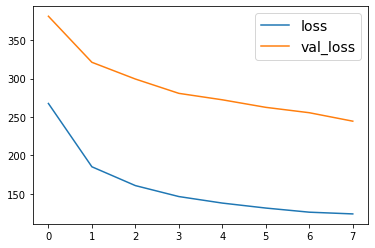

In [158]:
for name, values in history.history.items():
    plt.plot(values, label=name)
plt.legend(fontsize=14)
plt.show()

In [159]:
test_ds = timeseries_dataset_from_df(test, data_config["batch_size"])
rmse = model.evaluate(test_ds)**0.5
print(f"Test RMSE: {rmse:.2f}")

558/558 [==============================] - 7s 12ms/step - loss: 199.7908
Test RMSE: 14.13


# Save and Load the Model

## Save: Pickle our scaler and save our config to json

In [160]:
import json
import pickle

model.save("model")

with open("scaler.pck", "wb") as f:
    pickle.dump(scaler, f)

data_config["solar_wind_subset"] = SOLAR_WIND_FEATURES
print(data_config)
with open("config.json", "w") as f:
    json.dump(data_config, f)

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


{'timesteps': 32, 'batch_size': 32, 'solar_wind_subset': ['bt', 'temperature', 'bx_gsm', 'by_gsm', 'bz_gsm', 'speed', 'density']}


## Load Model and Scaler

In [161]:
import json
import pickle

import keras
import numpy as np
import pandas as pd

# Load in serialized model, config, and scaler
model = keras.models.load_model("model")


with open("config.json", "r") as f:
    CONFIG = json.load(f)

with open("scaler.pck", "rb") as f:
    scaler = pickle.load(f)


In [162]:
import pprint

print('CONFIG: '), pprint.pprint(CONFIG), print('\n')

model.summary()

print('Scaler:')
print(scaler)
pprint.pprint(scaler.__dict__)


CONFIG: 
{'batch_size': 32,
 'solar_wind_subset': ['bt',
                       'temperature',
                       'bx_gsm',
                       'by_gsm',
                       'bz_gsm',
                       'speed',
                       'density'],
 'timesteps': 32}


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                20480     
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 20,610
Trainable params: 20,610
Non-trainable params: 0
_________________________________________________________________
Scaler:
StandardScaler()
{'copy': True,
 'feature_names_in_': array(['bt_mean', 'bt_std', 'temperature_mean', 'temperature_std',
       'bx_gsm_mean', 'bx_gsm_std', 

# Explainable AI (XAI)

## Permutation Importance - Easy Approximation

Based on Christoph Molnar's "Interpretable Machine Learning" [Permutation Feature Importance](https://christophm.github.io/interpretable-ml-book/feature-importance.html) section and Fisher, Rudin, and Dominici (2018), we will "split the dataset in half and swap the values of feature j of the two halves instead of permuting feature j". 

Additional Resources:
*   [See this illustrative graphic demonstrating single- and multi-pass Permutation Importance](https://permutationimportance.readthedocs.io/en/latest/methods.html#permutation-importance)
*   [Permutation Feature Importance in the <i>scikit-learn</i> module](https://scikit-learn.org/stable/modules/permutation_importance.html)



Basically, we can split and swap the feature datasets one feature at a time and compare the resultant RMSE. We take a programming convenience shortcut and simply reverse a feature vector rather than split and swap and we expect the same results. 

Recall that our <i>test_ds</i> which we used to evaluate the model performance is a <i>[tensorflow.python.data.ops.dataset_ops.BatchDataset](https://www.tensorflow.org/guide/data#batching_dataset_elements)</i> and these are honestly kind of hard to work with. So we will recreate a deep copy of <i>test_ds</i> for each permutation and so we don't corrupt the original.

In [163]:
# FIXME: Getting that strange error, even though we already loaded these modules in "Build Model" 
#      AttributeError: module 'keras.preprocessing' has no attribute 'timeseries_dataset_from_array'
import tensorflow.keras as keras
from keras import preprocessing

In [164]:
# A couple of ways to learn about the contents of a BatchDataset:
#   print(list(train_ds.as_numpy_iterator()))
#   type(test_ds)


# We're going to edit this data so make a deep copy of our preprocessed training dataset.
test_for_permute = test.copy(deep=True)     

rmse_permute_df = pd.DataFrame(np.zeros((1,len(XCOLS))), columns=XCOLS)
n_times = len(test_for_permute)
for fname in XCOLS:

    # TODO: do real split, for now approximate with reversing the data in this feature
    test_for_permute[fname].values[:] = test_for_permute[fname].values[::-1]

    # create TensorFlow BatchDataset
    permute_ds = timeseries_dataset_from_df(test_for_permute, data_config["batch_size"])

    # evaluate model
    rmse_permute_df[fname] = model.evaluate(permute_ds)**0.5

    # undo data swap
    test_for_permute[fname].values[:] = test_for_permute[fname].values[::-1]

    print('%s: %f rmse' % (fname, rmse_permute_df[fname]))


558/558 [==============================] - 7s 12ms/step - loss: 238.2550
bt_mean: 15.435510 rmse
558/558 [==============================] - 7s 12ms/step - loss: 200.0602
temperature_mean: 14.144265 rmse
558/558 [==============================] - 7s 13ms/step - loss: 201.5447
bx_gsm_mean: 14.196645 rmse
558/558 [==============================] - 7s 13ms/step - loss: 208.1064
by_gsm_mean: 14.425893 rmse
558/558 [==============================] - 7s 13ms/step - loss: 369.3367
bz_gsm_mean: 19.218134 rmse
558/558 [==============================] - 7s 13ms/step - loss: 277.3203
speed_mean: 16.652937 rmse
558/558 [==============================] - 7s 13ms/step - loss: 204.3668
density_mean: 14.295691 rmse
558/558 [==============================] - 7s 12ms/step - loss: 206.3483
bt_std: 14.364830 rmse
558/558 [==============================] - 7s 12ms/step - loss: 201.4640
temperature_std: 14.193801 rmse
558/558 [==============================] - 7s 13ms/step - loss: 200.4443
bx_gsm_std: 14.157

In [165]:
# Ratio the Permuted RMSE to the overall RMSE and list in order of importance
print('In order of most important feature first to least important by rmse(j)/rmse:')
rmse_ratio_df = (rmse_permute_df/rmse).sort_values(ascending=False, by=0, axis=1)
rmse_ratio_df.T


In order of most important feature first to least important by rmse(j)/rmse:


,0
bz_gsm_mean,1.359638
speed_mean,1.178157
bt_mean,1.092027
smoothed_ssn,1.053334
by_gsm_mean,1.020599
bt_std,1.016278
density_mean,1.011387
speed_std,1.005903
bx_gsm_mean,1.004380
temperature_std,1.004179


In [166]:
rmse_ratio_df.iloc[0,0]

1.35963844535929

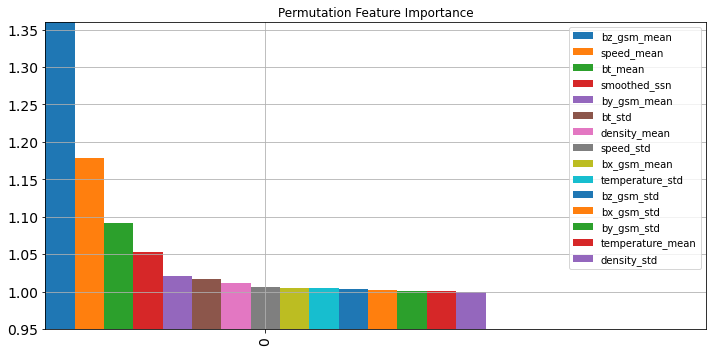

In [167]:
# visualize the Permutation Importance outcome
rmse_ratio_df.plot(kind='bar', figsize=(10, 5), fontsize=14)
plt.title('Permutation Feature Importance')
plt.xlim(-0.25,)
plt.ylim(0.95, rmse_ratio_df.iloc[0,0])
plt.grid(True)
plt.tight_layout()

### Review the feature Permutation Importances

<i>
How does the order of this list compare to your intuition from the Feature Correlation Heatmap we made earlier (aka heat map)?
</i>

## Student Exercise: SHapley Additive exPlanations (SHAP)

Use the SHapley Additive exPlanations (SHAP) by Lundberg and Lee (2017) methodology to explore the contribution of each feature on the predicted output labels for a specific event.

Resources you might like to explore:
*   [Interpreting your deep learning model by SHAP](https://towardsdatascience.com/interpreting-your-deep-learning-model-by-shap-e69be2b47893)
*   [Interpretable Machine Learning by Christop Molnar](https://christophm.github.io/interpretable-ml-book/shap.html)
*   [Keras LSTM for IMDB Sentiment Classification](https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Keras%20LSTM%20for%20IMDB%20Sentiment%20Classification.html?highlight=LSTM)

## Note on SKT-Explain

<div class="alert alert-block alert-warning">

While the current version of [skt-explain](https://github.com/monte-flora/scikit-explain) module isn't compatible with our tabular LSTM model (and sister CNN notebook), you might like to monitor this module's progress for your various needs--they have some really wonderful XAI tools and visualizations.

</div>

# Event Case Studies

## Define Prediction Function

In [168]:
from typing import Tuple

TIMESTEPS = data_config['timesteps']

def predict_dst(
    solar_wind_7d: pd.DataFrame,
    satellite_positions_7d: pd.DataFrame,
    latest_sunspot_number: float,
) -> Tuple[float, float]:
    """
    Take all of the data up until time t-1, and then make predictions for
    times t and t+1.
    Parameters
    ----------
    solar_wind_7d: pd.DataFrame
        The last 7 days of satellite data up until (t - 1) minutes [exclusive of t]
    satellite_positions_7d: pd.DataFrame
        The last 7 days of satellite position data up until the present time [inclusive of t]
    latest_sunspot_number: float
        The latest monthly sunspot number (SSN) to be available
    Returns
    -------
    predictions : Tuple[float, float]
        A tuple of two predictions, for (t and t + 1 hour) respectively; these should
        be between -2,000 and 500.
    """
    # Re-format data to fit into our pipeline
    sunspots = pd.DataFrame(index=solar_wind_7d.index, columns=["smoothed_ssn"])
    sunspots["smoothed_ssn"].values[:] = latest_sunspot_number
    
    # Process our features and grab last 32 (timesteps) hours
    features, s = preprocess_features(
        solar_wind_7d, sunspots, scaler=scaler, subset=SOLAR_WIND_FEATURES
    )
    model_input = features[-TIMESTEPS:][XCOLS].values.reshape(
        (1, TIMESTEPS, features.shape[1])
    )
    #pprint.pprint(features)
    
    # Make a prediction
    prediction_at_t0, prediction_at_t1 = model.predict(model_input)[0]

    # Optional check for unexpected values
    if not np.isfinite(prediction_at_t0):
        prediction_at_t0 = -12
    if not np.isfinite(prediction_at_t1):
        prediction_at_t1 = -12

    return prediction_at_t0, prediction_at_t1

## Ingest Real Event Data from Competition's "Private" Data

In [169]:
# Real Event Data from PRIVATE
DATA_PATH = Path("data/private/")
print('Importing data from: %s' % DATA_PATH)

dst = pd.read_csv(DATA_PATH / "dst_labels.csv")
dst.timedelta = pd.to_timedelta(dst.timedelta)
dst.set_index(["period", "timedelta"], inplace=True)

sunspots = pd.read_csv(DATA_PATH / "sunspots.csv")
sunspots.timedelta = pd.to_timedelta(sunspots.timedelta)
sunspots.set_index(["period", "timedelta"], inplace=True)

solar_wind = pd.read_csv(DATA_PATH / "solar_wind.csv")
solar_wind.timedelta = pd.to_timedelta(solar_wind.timedelta)
solar_wind.set_index(["period", "timedelta"], inplace=True)

satellite_positions = pd.read_csv(DATA_PATH / "satellite_positions.csv")
satellite_positions.timedelta = pd.to_timedelta(satellite_positions.timedelta)
satellite_positions.set_index(["period", "timedelta"], inplace=True)

Importing data from: data/private


## Event: Geomagnetic storm with Dst minimum of approx. -180 nT

<i>
How does our LSTM model output for this event look compared to our observed Dst?
How does our LSTM model performance compare to the CNN notebook for this event?
</i>

<i><b>Note: there are known bugs in this section that are being actively worked on.</b></i>

In [170]:
#####
# There are bugs in the section that are actively being worked out.
#####

event_start_day = 140
idx_event_1day = range(event_start_day,       event_start_day       + 7      )
idx_event_1hr  = range(event_start_day*24,    event_start_day*24    + 7*24   )
idx_event_1min = range(event_start_day*24*60, event_start_day*24*60 + 7*24*60)

dst_predicted_t0 = np.nan * np.zeros(len(idx_event_1hr))
dst_predicted_t1 = np.nan * np.zeros(len(idx_event_1hr))
i_dst = 0
###idx_1min = range((event_start_day-7)*24*60, event_start_day*24*60)
for i_offset_hour in range(-7*24, 0):
    
    # for the 
    idx_7day_1min = range(idx_event_1min[0]+i_offset_hour*60 - 1,  idx_event_1min[-1]+i_offset_hour*60 - 1)
    
    idx_7day_1day = range(idx_event_1day[0]+i_offset_hour//24, idx_event_1day[-1]+i_offset_hour//24)
    
    # Subset to 7 days around event
    solar_wind_7d_by_min          = solar_wind.iloc[idx_7day_1min]
    satellite_positions_7d_by_day = satellite_positions.iloc[idx_7day_1day]
    # FIXME: This sunspot number is correct for day 140. Use DF.join to generalize lining up the correct value.
    ###latest_sunspot_number = solar_wind_7d_by_min.join(sunspots).smoothed_ssn.mean()
    latest_sunspot_number = sunspots.iloc[5] 


    # Predict Dst
    dst_t0_t1 = predict_dst(solar_wind_7d=solar_wind_7d_by_min, satellite_positions_7d=satellite_positions_7d_by_day, latest_sunspot_number=latest_sunspot_number)

    dst_predicted_t0[i_dst] = dst_t0_t1[0]
    dst_predicted_t1[i_dst] = dst_t0_t1[1]

    i_dst += 1
    
    #print(solar_wind_7d_by_min)
    #print(satellite_positions_7d_by_day)
    print('Hour %4d: SSN %.1f, Bz %.1f nT, V %.0f km/s, Dst [t0,t1] = [%.1f, %.1f] nT' 
        % (i_offset_hour, latest_sunspot_number, solar_wind_7d_by_min['bz_gsm'].mean(), 
        solar_wind_7d_by_min['speed'].mean(), dst_t0_t1[0], dst_t0_t1[1]))


# Summarize final block of Input data
print('\nSummarizing final block of input data (head and tail):')
pprint.pprint(solar_wind_7d_by_min['bz_gsm'].head())
pprint.pprint(solar_wind_7d_by_min['bz_gsm'].tail())
pprint.pprint(satellite_positions_7d_by_day['gse_x_ace'].head())
pprint.pprint(satellite_positions_7d_by_day['gse_x_ace'].tail())
pprint.pprint(latest_sunspot_number)

Hour -168: SSN 180.3, Bz -0.0 nT, V 398 km/s, Dst [t0,t1] = [12.0, 11.5] nT
Hour -167: SSN 180.3, Bz 0.0 nT, V 396 km/s, Dst [t0,t1] = [11.5, 11.1] nT
Hour -166: SSN 180.3, Bz 0.1 nT, V 395 km/s, Dst [t0,t1] = [11.8, 11.4] nT
Hour -165: SSN 180.3, Bz 0.1 nT, V 394 km/s, Dst [t0,t1] = [11.1, 10.7] nT
Hour -164: SSN 180.3, Bz 0.1 nT, V 392 km/s, Dst [t0,t1] = [10.2, 10.0] nT
Hour -163: SSN 180.3, Bz 0.2 nT, V 391 km/s, Dst [t0,t1] = [17.3, 16.6] nT
Hour -162: SSN 180.3, Bz 0.2 nT, V 389 km/s, Dst [t0,t1] = [11.0, 10.7] nT
Hour -161: SSN 180.3, Bz 0.2 nT, V 388 km/s, Dst [t0,t1] = [10.3, 10.1] nT
Hour -160: SSN 180.3, Bz 0.2 nT, V 386 km/s, Dst [t0,t1] = [9.1, 9.0] nT
Hour -159: SSN 180.3, Bz 0.2 nT, V 385 km/s, Dst [t0,t1] = [8.4, 8.4] nT
Hour -158: SSN 180.3, Bz 0.2 nT, V 383 km/s, Dst [t0,t1] = [8.4, 8.2] nT
Hour -157: SSN 180.3, Bz 0.2 nT, V 382 km/s, Dst [t0,t1] = [6.7, 6.4] nT
Hour -156: SSN 180.3, Bz 0.2 nT, V 381 km/s, Dst [t0,t1] = [4.1, 3.4] nT
Hour -155: SSN 180.3, Bz 0.1 nT, V

In [171]:
# RMSE for this event:
rmse_t0 = np.mean((dst['dst'][idx_event_1hr] - dst_predicted_t0)**2)**0.5
rmse_t1 = np.mean((dst['dst'][idx_event_1hr] - dst_predicted_t1)**2)**0.5
print('RMSE to t0 precition: %f nT' % rmse_t0 )
print('RMSE to t1 precition: %f nT' % rmse_t1 )

RMSE to t0 precition: 43.553024 nT
RMSE to t1 precition: 43.673487 nT


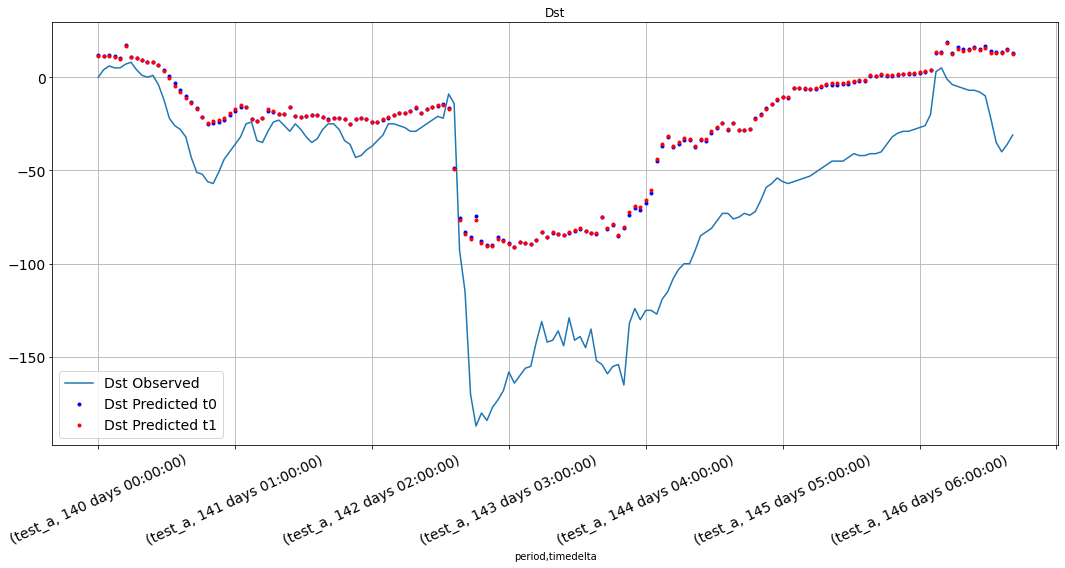

In [172]:
# Dst Observed
ax = dst['dst'][idx_event_1hr].plot(title='Dst', rot=25, figsize=(15, 8), fontsize=14, label='Dst Observed')
# Dst Predicted
ax.plot(dst_predicted_t0, 'b.', label='Dst Predicted t0')
# TODO: check that the time axis is correct for t1.
ax.plot(dst_predicted_t1, 'r.', label='Dst Predicted t1')
plt.grid(True)
plt.legend(fontsize=14)
plt.tight_layout()

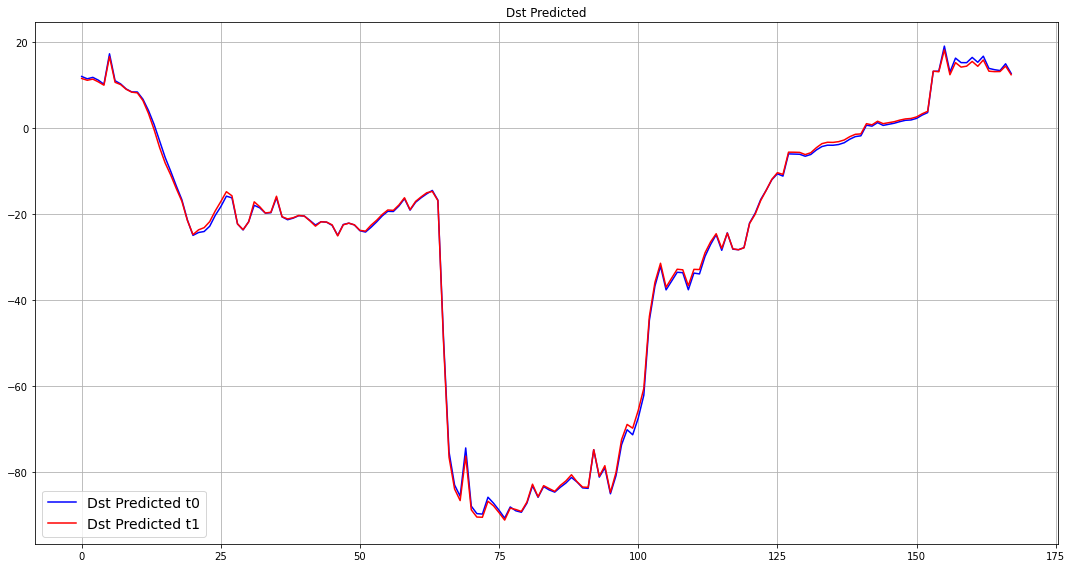

In [173]:
# Dst Predicted
fig = plt.figure(figsize=(15, 8))

plt.plot(dst_predicted_t0, 'b', label='Dst Predicted t0')
plt.plot(dst_predicted_t1, 'r', label='Dst Predicted t1')
plt.grid(True)
plt.legend(fontsize=14)
plt.title('Dst Predicted')

plt.tight_layout()

## Student Exercise: Additional Case Studies

Look at the CNN notebook and add additional events here and compare the LSTM and CNN performance for each event.

<i>
Are there events where LSTM is close to performing as well?
</i>

## Student Exercise: Degraded or Adverserial Data - How robust is the model?

<div class="alert alert-block alert-warning">
Students: Here's your chance to degrade the instrument measurements and run the model to see how the performance is impacted. Start simple by adding Gaussian noise (mean 0), to the least important and the most important input parameters (aka features) and evaluating a specific event. You could also fold in the SHAP methodology here.
</div>